In [1]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as cs

from scipy.interpolate import CubicSpline
from casadi import SX, MX, vertcat, Function
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel, AcadosSimSolver, AcadosSim, builders


In [2]:
N_horizon = 13
L = 0.258
v_max = 3.0
ts = 0.021
tf = ts * N_horizon

# Cost weights
Q_s = 0.1
Q_e_y = 20.0  # Lateral error weight
Q_e_theta = 20.0 # Yaw error weight
Q_v = 0.0 
Q_delta = 5.0
R_a = 1.0   # Control effort weight (a)
R_omega = 0.0   # Control effort weight (omega)

nx = 7
nx_sim = 5
nu = 2
ny = 7
ny_e = 5

n_Vx = 5
n_Vu = 2

In [3]:
# Define the reference lane interpolation
def interpolate_lane(
        control_points: np.ndarray,
        randomness: float = 0.0,
        num_samples: int = 100,
) -> tuple[np.ndarray, np.ndarray]:
    t_all = np.linspace(0, 1, num_samples)

    x_ref = (1 - t_all)**3 * control_points[0, 0] \
          + 3 * (1 - t_all)**2 * t_all * control_points[1, 0] \
          + 3 * (1 - t_all) * t_all**2 * control_points[2, 0] \
          + t_all**3 * control_points[3, 0]
    
    y_ref = (1 - t_all)**3 * control_points[0, 1] \
          + 3 * (1 - t_all)**2 * t_all * control_points[1, 1] \
          + 3 * (1 - t_all) * t_all**2 * control_points[2, 1] \
          + t_all**3 * control_points[3, 1]

    x_ref += randomness * np.random.randn(len(x_ref))
    y_ref += randomness * np.random.randn(len(y_ref))
    
    return x_ref, y_ref


def plot_lines(*lines: tuple[np.ndarray, np.ndarray, dict], title="") -> None:
    plt.figure(figsize=(10, 6))
    
    # Check if labels are provided, and ensure they match the number of lines
    for i, (x, y, args) in enumerate(lines):
        plt.plot(x, y, **args)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.axis("equal")
    plt.show()

In [4]:
def define_bicycle_model() -> AcadosModel:
    s = MX.sym('s')                 # Path progress
    e_y = MX.sym('e_y')             # lateral error
    e_theta = MX.sym('e_theta')     # heading error
    v = MX.sym('v')                 # velocity
    delta = MX.sym('delta')         # steering angle
    x = cs.MX.sym('x')              # Global x position (m)
    y = cs.MX.sym('y')              # Global x position (m)
    states = vertcat(s, e_y, e_theta, v, delta, x, y)
    
    a = MX.sym('a')                 # acceleration
    omega = MX.sym('omega')         # steering rate
    controls = vertcat(a, omega)    

    # Reference trajectory parameters
    p = MX.sym('p', 8)
    chord = cs.sqrt((p[6]-p[0])**2 + (p[7]-p[1])**2)
    cp1   = cs.sqrt((p[2]-p[0])**2 + (p[3]-p[1])**2)
    cp2   = cs.sqrt((p[4]-p[2])**2 + (p[5]-p[3])**2)
    cp3   = cs.sqrt((p[6]-p[4])**2 + (p[7]-p[5])**2)
    L_total_expr = 0.5 * (chord + cp1 + cp2 + cp3)
    t_raw = s / L_total_expr
    t = cs.fmin(1.0, cs.fmax(0.0, t_raw))
    
    # Define the 2D Bézier curve for the lane geometry:
    x_lane = (1 - t)**3 * p[0] + 3*(1 - t)**2 * t * p[2] \
           + 3*(1 - t) * t**2 * p[4] + t**3 * p[6]
    y_lane = (1 - t)**3 * p[1] + 3*(1 - t)**2 * t * p[3] \
           + 3*(1 - t) * t**2 * p[5] + t**3 * p[7]
    
    # Compute derivatives with respect to s
    dx_ds   = cs.jacobian(x_lane, s)   # first derivative of x
    d2x_ds2 = cs.jacobian(dx_ds, s)      # second derivative of x
    dy_ds   = cs.jacobian(y_lane, s)     # first derivative of y
    d2y_ds2 = cs.jacobian(dy_ds, s)       # second derivative of y
    
    # Compute curvature κ(s):
    #   κ(s) = (dx/ds * d2y/ds2 - dy/ds * d2x/ds2) / ((dx/ds)^2 + (dy/ds)^2)^(3/2)
    numerator   = dx_ds * d2y_ds2 - dy_ds * d2x_ds2
    denominator = (dx_ds**2 + dy_ds**2)**(3/2)
    kappa = numerator / denominator

    theta_lane = cs.atan2(dy_ds, dx_ds)
    theta_vehicle = theta_lane + e_theta

    # Dynamics
    # (Note: the term 1 - kappa * e_y in the denominator “projects” the speed along the path)
    s_dot = v * MX.cos(e_theta) / (1 - kappa * e_y)
    e_y_dot = v * MX.sin(e_theta)
    e_theta_dot = v / L * MX.tan(delta) - kappa * s_dot
    v_dot = a
    delta_dot = omega
    x_dot_global = v * cs.cos(theta_vehicle)
    y_dot_global = v * cs.sin(theta_vehicle)
    
    f = vertcat(s_dot, e_y_dot, e_theta_dot, v_dot, delta_dot, x_dot_global, y_dot_global)

    # Discs of Model for nonlinear constraints
    r = 0.05
    x_r = 0.5
    y_r = 0.1
    h_expr = - r + cs.sqrt((x - x_r)**2 + (y - y_r)**2)

    model = AcadosModel()
    model.f_expl_expr = f
    model.x = states
    model.u = controls
    model.p = p
    model.name = "bicycle_model" 
    # model.con_h_expr = h_expr
    return model


# Setup acados OCP
def setup_acados_ocp_solver() -> AcadosOcpSolver:
    # Define OCP
    ocp = AcadosOcp()
    ocp.model = define_bicycle_model()

    # Constraints
    ocp.constraints.x0 = np.zeros(nx)
    ocp.parameter_values = np.zeros(8)
    # ocp.dims.nh = 1
    # ocp.dims.nh_0 = 1
    # ocp.dims.nh_e = 1

    ocp.constraints.lbx = np.array([0, -1e3, -1e2, 0, -0.35, -1e2, -1e2])
    ocp.constraints.ubx = np.array([5, 1e3, 1e2, v_max, 0.35, 1e2, 1e2])
    ocp.constraints.idxbx = np.arange(7)

    ocp.constraints.lbx_e = np.array([0, -1e2, -1e2, 0, -0.35, -1e2, -1e2])
    ocp.constraints.ubx_e = np.array([5, 1e2, 1e2, v_max, 0.35, 1e2, 1e2])
    ocp.constraints.idxbx_e = np.arange(7)

    ocp.constraints.lbu = np.array([0.0, -1e2])
    ocp.constraints.ubu = np.array([6.0, 1e2])
    ocp.constraints.idxbu = np.arange(2)

    # ocp.constraints.lh = np.array([-1e2])
    # ocp.constraints.uh = np.array([1e2])

    ocp.cost.cost_type = "LINEAR_LS"
    ocp.cost.W = np.diag([Q_s, Q_e_y, Q_e_theta, Q_v, Q_delta, R_a, R_omega])
    ocp.cost.Vx = np.zeros((ny, nx))
    ocp.cost.Vx[:n_Vx, :n_Vx] = np.eye(n_Vx)
    ocp.cost.Vu = np.zeros((ny, nu))
    ocp.cost.Vu[n_Vx:, :] = np.eye(n_Vu)
    ocp.cost.yref = np.zeros(ny)
    ocp.cost.yref[0] = 1e2
    ocp.cost.yref[3] = v_max

    ocp.cost.cost_type_e = "LINEAR_LS"
    ocp.cost.W_e = np.diag([Q_s, Q_e_y, Q_e_theta, Q_v, Q_delta])
    ocp.cost.Vx_e = np.zeros((ny_e, nx))
    ocp.cost.Vx_e[:n_Vx, :n_Vx] = np.eye(n_Vx)
    ocp.cost.yref_e = np.zeros(n_Vx)
    ocp.cost.yref_e[0] = 1e2
    ocp.cost.yref[3] = v_max

    # Solver Options
    ocp.solver_options.N_horizon = N_horizon
    ocp.solver_options.tf = tf
    ocp.solver_options.qp_solver = "FULL_CONDENSING_HPIPM"
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP_RTI"
    ocp.solver_options.sim_method_num_stages = 4
    ocp.solver_options.hpipm_mode = "SPEED"
    # ocp.solver_options.as_rti_level = 3
    # ocp.solver_options.as_rti_iter = 3
    # ocp.solver_options.qp_solver_warm_start = True
    # ocp.solver_options.levenberg_marquardt = 0.2
    # ocp.solver_options.rti_phase = 1
    ocp.solver_options.nlp_solver_tol_stat = 1e-4
    ocp.solver_options.nlp_solver_tol_comp = 1e-4
    ocp.solver_options.nlp_solver_tol_eq = 1e-3
    ocp.solver_options.nlp_solver_tol_ineq = 1e-2

    cm_builder = builders.ocp_get_default_cmake_builder()
    cm_builder.options_on = [
        'BUILD_ACADOS_OCP_SOLVER_LIB',
        'BUILD_ACADOS_SOLVER_LIB'
    ]
    return AcadosOcpSolver(ocp, json_file='bicycle_model.json', cmake_builder=cm_builder)

In [5]:
def define_bicycle_sim_model() -> AcadosModel:
    """
    Defines a standard bicycle model in the inertial frame.
    
    States:
    -------
    - x     : x-position
    - y     : y-position
    - theta : vehicle heading angle
    - v     : vehicle speed
    - delta : steering angle
    
    Controls:
    ---------
    - a     : acceleration
    - omega : steering rate
    """
    # Define states
    x     = MX.sym('x')
    y     = MX.sym('y')
    theta = MX.sym('theta')
    v     = MX.sym('v')
    delta = MX.sym('delta')
    states = cs.vertcat(x, y, theta, v, delta)
    
    # Define controls
    a     = MX.sym('a')
    omega = MX.sym('omega')
    controls = cs.vertcat(a, omega)
    
    # Define the dynamics (explicit ODE form)
    x_dot = cs.vertcat(
        v * cs.cos(theta),         # dot(x)
        v * cs.sin(theta),         # dot(y)
        v / L * cs.tan(delta),     # dot(theta)
        a,                         # dot(v)
        omega                      # dot(delta)
    )
    
    # Create the simulation model
    model = AcadosModel()
    model.f_expl_expr = x_dot
    model.x = states
    model.u = controls
    model.name = "bicycle_sim"
    return model


def setup_acados_sim_solver() -> AcadosSimSolver:
    """
    Sets up the Acados simulator for the standard bicycle model.
    Uses an explicit Runge-Kutta integrator with a simulation time step.
    """
    sim = AcadosSim()
    sim.model = define_bicycle_sim_model()
    
    # Set simulator options:
    sim.solver_options.integrator_type = "ERK"  # Explicit Runge-Kutta
    sim.solver_options.T = ts  # simulation time step (seconds)
    return AcadosSimSolver(sim, json_file="bicycle_sim.json")

In [6]:
def solve_ocp(control_points: np.ndarray):
    ocp_solver = setup_acados_ocp_solver()
    sim_solver = setup_acados_sim_solver()

    state = np.array([0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0]) # [s, e_y, e_theta, v, delta, x_global, y_global]
    sim_state = np.array([0.0, 0.0, 0.0, 1.5, 0.0])  # [x, y, theta, v, delta]

    # Store results for plotting
    state_trajectories = np.full((N_horizon+1, nx), np.nan)
    input_trajectories = np.full((N_horizon, nu), np.nan)
    sim_state_trajectories = np.full((N_horizon+1, nx_sim), np.nan)

    # Solve OCP
    ocp_solver.options_set("rti_phase", 1)
    status = ocp_solver.solve()

    bezier_params = control_points.flatten()
    print(bezier_params)
    for k in range(N_horizon):
        ocp_solver.set(k, "p", bezier_params)
    ocp_solver.set(0, 'lbx', state)
    ocp_solver.set(0, 'ubx', state)

    ocp_solver.options_set("rti_phase", 2)
    status = ocp_solver.solve()

    ocp_solver.print_statistics()

    print("Solving time: ", ocp_solver.get_stats("time_tot"))
    if status != 0:
        print(f"Solver failed with status {status}")
    
    # Simulation Solve
    state_trajectories[0, :] = state
    sim_state_trajectories[0, :] = sim_state

    x_next = sim_state
    for i in range(N_horizon):
        u_curr = ocp_solver.get(i, "u")
        input_trajectories[i, :] = u_curr
        state_trajectories[i+1, :] = ocp_solver.get(i+1, "x")

        sim_solver.set("x", x_next)
        sim_solver.set("u", u_curr)
        status = sim_solver.solve()
        if status != 0:
            raise Exception(f"Acados simulator returned non-zero status at stage {i}")
        x_next = sim_solver.get("x")
        sim_state_trajectories[i+1, :] = x_next
    return state_trajectories, input_trajectories, sim_state_trajectories

call("cmake -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX="/home/argo/programmier_stuff/UNI/psaf/wise-2024-25-tokyodrift/src/2_plan/mpc/c_generated_code" -DBUILD_ACADOS_OCP_SOLVER_LIB=ON  -DBUILD_ACADOS_SOLVER_LIB=ON -Wdev -S"/home/argo/programmier_stuff/UNI/psaf/wise-2024-25-tokyodrift/src/2_plan/mpc/c_generated_code" -B"/home/argo/programmier_stuff/UNI/psaf/wise-2024-25-tokyodrift/src/2_plan/mpc/c_generated_code/build")"
-- Configuring done
-- Generating done
-- Build files have been written to: /home/argo/programmier_stuff/UNI/psaf/wise-2024-25-tokyodrift/src/2_plan/mpc/c_generated_code/build
call("cmake --build "/home/argo/programmier_stuff/UNI/psaf/wise-2024-25-tokyodrift/src/2_plan/mpc/c_generated_code/build" --config Release -j8")
Consolidate compiler generated dependencies of target sim_bicycle_model
Consolidate compiler generated dependencies of target ocp_bicycle_model
Consolidate compiler generated dependencies of target model_bicycle_model
[ 28%] Building C object CMake

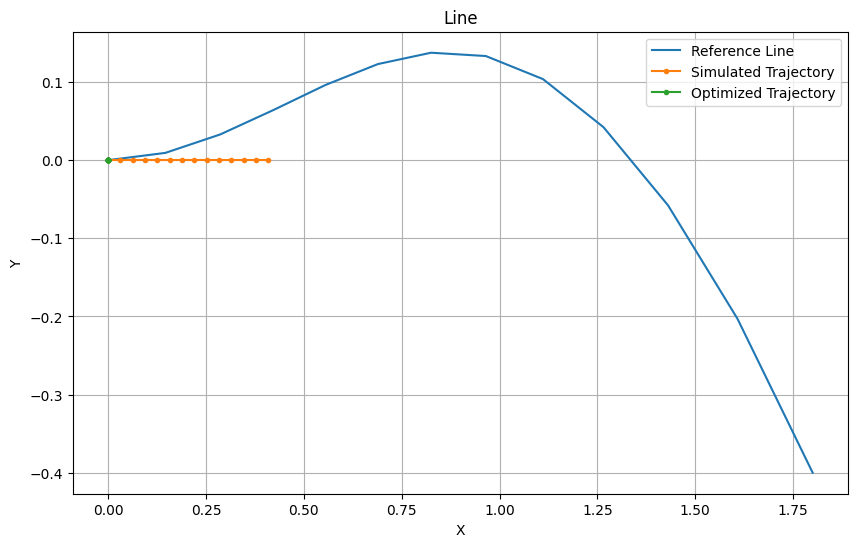

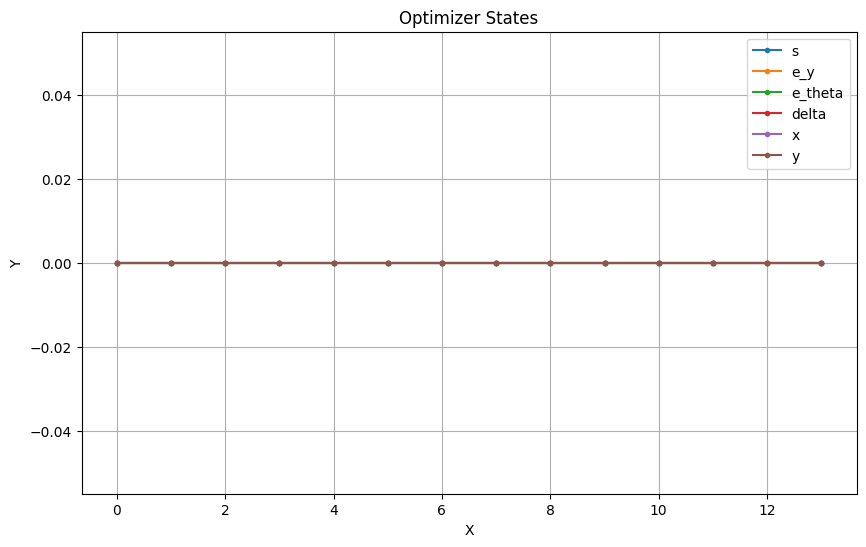

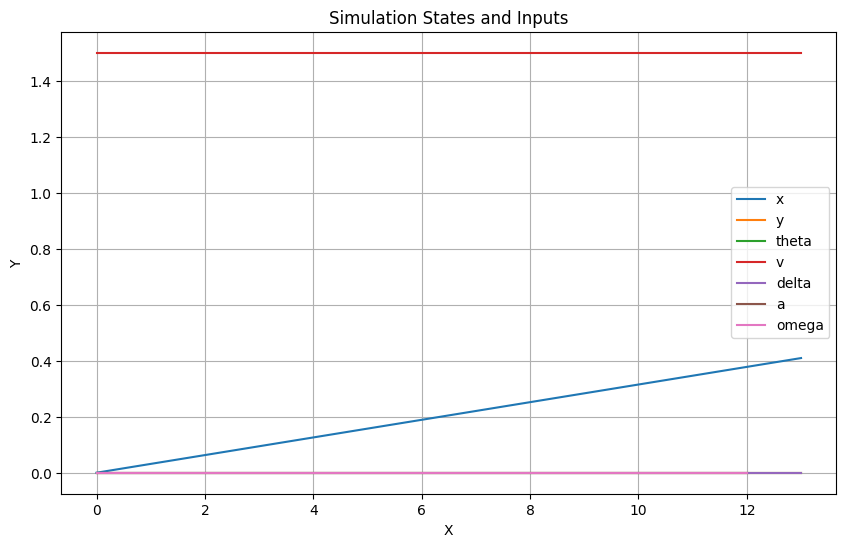

In [7]:
control_points = np.array([
    [0.0, 0.0],
    [0.6, 0.0],
    [1., 0.5],
    [1.8, -0.4]
])
# Simulation settings
x_ref, y_ref = interpolate_lane(control_points, randomness=0.0, num_samples=N_horizon)
states, inputs, sim_states = solve_ocp(control_points)
linsp_state = np.linspace(0, N_horizon, N_horizon + 1)
linsp_input = np.linspace(0, N_horizon - 1, N_horizon)

plot_lines(
    (x_ref, y_ref, {"label":"Reference Line"}),
    (sim_states[:, 0], sim_states[:, 1], {"label":"Simulated Trajectory", "marker":"."}),
    (states[:, 5], states[:, 6], {"label":"Optimized Trajectory", "marker":"."}),
    title="Line"
)

plot_lines(
    (
        np.tile(linsp_state, (states.shape[1]-1, 1)).T, 
        np.delete(states, (3), axis=1), 
        {"label":["s", "e_y", "e_theta", "delta", "x", "y"], "marker":"."}
    ),
    title="Optimizer States"
)

plot_lines(
    (
        np.tile(linsp_state, (sim_states.shape[1], 1)).T, 
        sim_states, 
        {"label":["x", "y", "theta", "v", "delta"]}
    ),
    (
        np.tile(linsp_input, (inputs.shape[1], 1)).T, 
        inputs, 
        {"label":["a", "omega"]}
    ),
    title="Simulation States and Inputs"
)